<a href="https://colab.research.google.com/github/inoculate23/KandinskyVideo/blob/main/Copy_of_Video_interpolation_and_upscaling_Real_ESRGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup (~1 minute)

# Frame Interpolation

In [ ]:
import torch
assert torch.cuda.is_available(), "GPU not detected.. Please change runtime to GPU"

from PIL import Image
import cv2, os, subprocess
from google.colab import drive
from tqdm import tqdm

!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN

!pip install -q torch==2.0.1 torchvision==0.15.2 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install -q basicsr facexlib gfpgan ffmpeg ffmpeg-python
!pip install -q -r requirements.txt
!python setup.py develop

mount_drive=True #@param{type:"boolean"}

if mount_drive:
  drive.mount('/content/gdrive/')

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 759 (delta 0), reused 0 (delta 0), pack-reused 757 (from 2)
Receiving objects: 100% (759/759), 5.39 MiB | 19.49 MiB/s, done.
Resolving deltas: 100% (406/406), done.
/content/Real-ESRGAN/Real-ESRGAN
/usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.11/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWa

In [ ]:
!pip install mediapy
!sudo apt-get install -y ffmpeg





Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
import numpy as np

from typing import Generator, Iterable, List, Optional
import mediapy as media

In [ ]:
model = hub.load("https://tfhub.dev/google/film/1")

# util_function_to_load_images_from_a_url_or_locally

In [ ]:
_UINT8_MAX_F = float(np.iinfo(np.uint8).max)

def load_image(img_url: str):
  """Returns an image with shape [height, width, num_channels], with pixels in [0..1] range, and type np.float32."""

  if (img_url.startswith("https")):
    user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
    response = requests.get(img_url, headers=user_agent)
    image_data = response.content
  else:
    image_data = tf.io.read_file(img_url)

  image = tf.io.decode_image(image_data, channels=3)
  image_numpy = tf.cast(image, dtype=tf.float32).numpy()
  return image_numpy / _UINT8_MAX_F

In [ ]:
# using images from the FILM repository (https://github.com/google-research/frame-interpolation/)

image_1_url = "/content/bear.png"
image_2_url = "/content/clown.png"

time = np.array([0.5], dtype=np.float32)

image1 = load_image(image_1_url)
image2 = load_image(image_2_url)

In [ ]:
input = {
    'time': np.expand_dims(time, axis=0), # adding the batch dimension to the time
     'x0': np.expand_dims(image1, axis=0), # adding the batch dimension to the image
     'x1': np.expand_dims(image2, axis=0)  # adding the batch dimension to the image
}
mid_frame = model(input)

dict_keys(['forward_flow_pyramid', 'image', 'x1_warped', 'backward_flow_pyramid', 'backward_residual_flow_pyramid', 'x0_warped', 'forward_residual_flow_pyramid'])


input image one,generated image,input image two

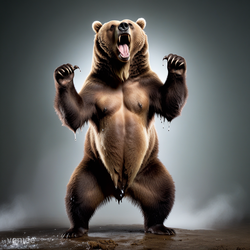
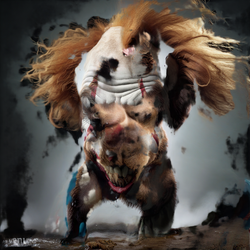
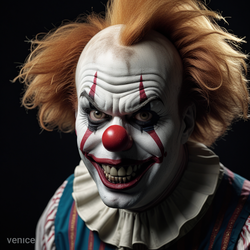

In [ ]:
print(mid_frame.keys())
frames = [image1, mid_frame['image'][0].numpy(), image2]

media.show_images(frames, titles=['input image one', 'generated image', 'input image two'], height=250)




In [ ]:
media.show_video(frames, fps=3, title='FILM interpolated video')

In [ ]:
"""A wrapper class for running a frame interpolation based on the FILM model on TFHub

Usage:
  interpolator = Interpolator()
  result_batch = interpolator(image_batch_0, image_batch_1, batch_dt)
  Where image_batch_1 and image_batch_2 are numpy tensors with TF standard
  (B,H,W,C) layout, batch_dt is the sub-frame time in range [0..1], (B,) layout.
"""


def _pad_to_align(x, align):
  """Pads image batch x so width and height divide by align.

  Args:
    x: Image batch to align.
    align: Number to align to.

  Returns:
    1) An image padded so width % align == 0 and height % align == 0.
    2) A bounding box that can be fed readily to tf.image.crop_to_bounding_box
      to undo the padding.
  """
  # Input checking.
  assert np.ndim(x) == 4
  assert align > 0, 'align must be a positive number.'

  height, width = x.shape[-3:-1]
  height_to_pad = (align - height % align) if height % align != 0 else 0
  width_to_pad = (align - width % align) if width % align != 0 else 0

  bbox_to_pad = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height + height_to_pad,
      'target_width': width + width_to_pad
  }
  padded_x = tf.image.pad_to_bounding_box(x, **bbox_to_pad)
  bbox_to_crop = {
      'offset_height': height_to_pad // 2,
      'offset_width': width_to_pad // 2,
      'target_height': height,
      'target_width': width
  }
  return padded_x, bbox_to_crop


class Interpolator:
  """A class for generating interpolated frames between two input frames.

  Uses the Film model from TFHub
  """

  def __init__(self, align: int = 64) -> None:
    """Loads a saved model.

    Args:
      align: 'If >1, pad the input size so it divides with this before
        inference.'
    """
    self._model = hub.load("https://tfhub.dev/google/film/1")
    self._align = align

  def __call__(self, x0: np.ndarray, x1: np.ndarray,
               dt: np.ndarray) -> np.ndarray:
    """Generates an interpolated frame between given two batches of frames.

    All inputs should be np.float32 datatype.

    Args:
      x0: First image batch. Dimensions: (batch_size, height, width, channels)
      x1: Second image batch. Dimensions: (batch_size, height, width, channels)
      dt: Sub-frame time. Range [0,1]. Dimensions: (batch_size,)

    Returns:
      The result with dimensions (batch_size, height, width, channels).
    """
    if self._align is not None:
      x0, bbox_to_crop = _pad_to_align(x0, self._align)
      x1, _ = _pad_to_align(x1, self._align)

    inputs = {'x0': x0, 'x1': x1, 'time': dt[..., np.newaxis]}
    result = self._model(inputs, training=False)
    image = result['image']

    if self._align is not None:
      image = tf.image.crop_to_bounding_box(image, **bbox_to_crop)
    return image.numpy()

In [ ]:
def _recursive_generator(
    frame1: np.ndarray, frame2: np.ndarray, num_recursions: int,
    interpolator: Interpolator) -> Generator[np.ndarray, None, None]:
  """Splits halfway to repeatedly generate more frames.

  Args:
    frame1: Input image 1.
    frame2: Input image 2.
    num_recursions: How many times to interpolate the consecutive image pairs.
    interpolator: The frame interpolator instance.

  Yields:
    The interpolated frames, including the first frame (frame1), but excluding
    the final frame2.
  """
  if num_recursions == 0:
    yield frame1
  else:
    # Adds the batch dimension to all inputs before calling the interpolator,
    # and remove it afterwards.
    time = np.full(shape=(1,), fill_value=0.5, dtype=np.float32)
    mid_frame = interpolator(
        np.expand_dims(frame1, axis=0), np.expand_dims(frame2, axis=0), time)[0]
    yield from _recursive_generator(frame1, mid_frame, num_recursions - 1,
                                    interpolator)
    yield from _recursive_generator(mid_frame, frame2, num_recursions - 1,
                                    interpolator)


def interpolate_recursively(
    frames: List[np.ndarray], num_recursions: int,
    interpolator: Interpolator) -> Iterable[np.ndarray]:
  """Generates interpolated frames by repeatedly interpolating the midpoint.

  Args:
    frames: List of input frames. Expected shape (H, W, 3). The colors should be
      in the range[0, 1] and in gamma space.
    num_recursions: Number of times to do recursive midpoint
      interpolation.
    interpolator: The frame interpolation model to use.

  Yields:
    The interpolated frames (including the inputs).
  """
  n = len(frames)
  for i in range(1, n):
    yield from _recursive_generator(frames[i - 1], frames[i],
                                    times_to_interpolate, interpolator)
  # Separately yield the final frame.
  yield frames[-1]

In [ ]:
times_to_interpolate = 6
interpolator = Interpolator()

In [ ]:
input_frames = [image1, image2]
frames = list(
    interpolate_recursively(input_frames, times_to_interpolate,
                                        interpolator))

In [ ]:
print(f'video with {len(frames)} frames')
media.show_video(frames, fps=23, title='FILM interpolated video')

video with 65 frames


# 4k Video Upscaler Colab (Real-ESRGAN)

Adapted from: [Real-ESRGAN](https://github.com/xinntao/Real-ESRGAN)


Github repository: https://github.com/yuvraj108c/4k-video-upscaler-colab

# Upscale video

- The upscaled video will be saved to `output_dir`
- If google drive is mounted, it will be also saved at `MyDrive/Upscaled Videos (REAL-ESRGAN)`


In [ ]:
video_path="/content/000002.mp4" #@param{type:"string"}
output_dir="/gdrive/MyDrive/bshop_upscaled" #@param{type:"string"}
resolution = "4k (3840 x 2160)" # @param ["FHD (1920 x 1080)", "2k (2560 x 1440)", "4k (3840 x 2160)","2 x original", "3 x original", "4 x original"] {type:"string"}
model = "RealESRGAN_x4plus" #@param ["RealESRGAN_x4plus" , "RealESRGAN_x4plus_anime_6B", "realesr-animevideov3"]

assert os.path.exists(video_path), "Video file does not exist"

video_capture = cv2.VideoCapture(video_path)
video_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

final_width = None
final_height = None
aspect_ratio = float(video_width/video_height)

# Get output resolutions
match resolution:
  case "FHD (1920 x 1080)":
    final_width=1920
    final_height=1080
  case "2k (2560 x 1440)":
    final_width=2560
    final_height=1440
  case "4k (3840 x 2160)":
    final_width=3840
    final_height=2160
  case "2 x original":
    final_width=2*video_width
    final_height=2*video_height
  case "3 x original":
    final_width=3*video_width
    final_height=3*video_height
  case "4 x original":
    final_width=4*video_width
    final_height=4*video_height

if aspect_ratio == 1.0 and "original" not in resolution:
  final_height = final_width

if aspect_ratio < 1.0 and "original" not in resolution:
  temp = final_width
  final_width = final_height
  final_height = temp

scale_factor = max(final_width/video_width, final_height/video_height)
isEven = int(video_width * scale_factor) % 2 == 0 and int(video_height * scale_factor) % 2 == 0

# scale_factor needs to be even
while isEven == False:
  scale_factor += 0.01
  isEven = int(video_width * scale_factor) % 2 == 0 and int(video_height * scale_factor) % 2 == 0

print(f"Upscaling from {video_width}x{video_height} to {final_width}x{final_height}, scale_factor={scale_factor}")

!python inference_realesrgan_video.py -n {model} -i '{video_path}' -o '{output_dir}' --outscale {scale_factor}

video_name_with_ext = os.path.basename(video_path)
video_name = video_name_with_ext.replace(".mp4","")
upscaled_video_path = f"{output_dir}{video_name}_out.mp4"
final_video_name = f"{video_name}_upscaled_{final_width}_{final_height}.mp4"
final_video_path = os.path.join(output_dir, final_video_name)

# crop to fit
if "original" not in resolution:
  print("Cropping to fit...")
  command = f"ffmpeg -loglevel error -hwaccel cuda -y -i '{upscaled_video_path}' -c:v h264_nvenc -filter:v  'crop={final_width}:{final_height}:(in_w-{final_width})/2:(in_h-{final_height})/2' -c:v libx264 -pix_fmt yuv420p '{final_video_path}'"
  subprocess.run(command,shell=True)

print(f"Upscaled video saved to: {final_video_path}")

# save to drive
if mount_drive:
  drive_folder = "MyDrive/Upscaled Videos (REAL-ESRGAN)"
  save_directory_drive = f"/content/gdrive/{drive_folder}"
  os.makedirs(save_directory_drive, exist_ok=True)

  command = f"'{final_video_path}' '{save_directory_drive}'/'{final_video_name}'"
  subprocess.run(command,shell=True)
  print(f"Saved to drive: /{drive_folder}/{final_video_name}" )

!rm "{upscaled_video_path}"

Upscaling from 672x384 to 3840x2160, scale_factor=5.714285714285714
/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
You are generating video that is larger than 4K, which will be very slow due to IO speed. We highly recommend to decrease the outscale(aka, -s).
inference: 100% 97/97 [03:32<00:00,  2.19s/frame]
Cropping to fit...
Upscaled video saved to: /gdrive/MyDrive/bshop_upscaled/000002_upscaled_3840_2160.mp4
Saved to drive: /MyDrive/Upscaled Videos (REAL-ESRGAN)/000002_upscaled_3840_2160.mp4
rm: cannot remove '/gdrive/MyDrive/bshop_upscaled000002_out.mp4': No such file or directory


In [ ]:
from google.colab import runtime

disconnect_when_finish = False  #@param{type:"boolean"}

if disconnect_when_finish:
  runtime.unassign()